In [80]:
import yfinance as yf
import pandas as pd
import vectorbt as vbt
import numpy as np
from datetime import datetime, timedelta
import pytz

In [131]:
# Define the list of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Replace with your portfolio tickers

# Fetch historical data from yfinance
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
start_date = datetime(2018, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime.now(pytz.utc).replace(hour=0, minute=0, second=0, microsecond=0)
time_buffer = timedelta(days=100)
data = vbt.YFData.download(tickers, start=start_date-time_buffer, end=end_date).get(cols)

# data = data.astype(np.float64)
# data

AttributeError: 'tuple' object has no attribute 'astype'

In [144]:
# Create a copy of data without time buffer
# data.index = pd.to_datetime(data.index)
wobuf_mask = (data[0].index >= start_date) & (data[0].index <= end_date) # mask without buffer



# Extract relevant data
close = data[3].astype(np.float64)[wobuf_mask]
high = data[1].astype(np.float64)[wobuf_mask]
low = data[2].astype(np.float64)[wobuf_mask]
volume = data[4].astype(np.float64)[wobuf_mask]
ope = data[0].astype(np.float64)[wobuf_mask]

# Calculate indicators using vectorbt
stoch = vbt.IndicatorFactory.from_talib('STOCH').run(high, low, close)
sma_50 = vbt.MA.run(ope, window=20)
sma_200 = vbt.MA.run(ope, window=50)
obv = vbt.IndicatorFactory.from_talib('OBV').run(close, volume.astype(float))

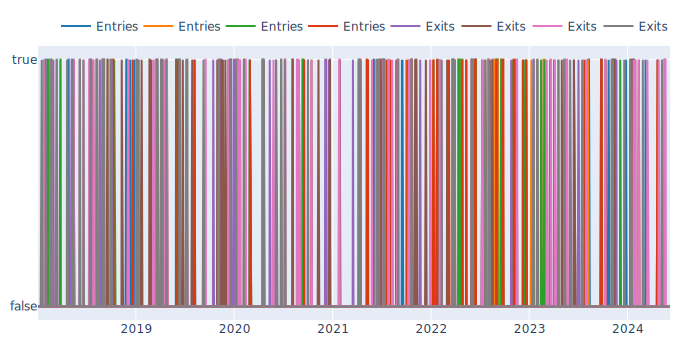

In [165]:
buy_signal = (stoch.slowk < 20) & (stoch.slowk> stoch.slowd) #& sma_50.ma_above(sma_200) #& (obv.real.diff() > 0)
sell_signal = (stoch.slowk > 80) & (stoch.slowk < stoch.slowd)# & sma_50.ma_below(sma_200) #& (obv.real.diff() < 0)

# buy_signal =  sma_50.ma_crossed_above(sma_200) #& (obv.real.diff() > 0)
# sell_signal =  sma_50.ma_crossed_below(sma_200) #& (obv.real.diff() < 0)
#(stoch.slowk < 20) & (stoch.slowk> stoch.slowd) &
#(stoch.slowk > 80) & (stoch.slowk < stoch.slowd) &
# Create entries and exits
entries = buy_signal.vbt.signals#.any(axis=1)
exits = sell_signal.vbt.signals#.any(axis=1)

fig = entries.plot(trace_kwargs=dict(name='Entries'))
exits.plot(trace_kwargs=dict(name='Exits'), fig=fig).show_svg()

In [166]:
# Backtest the portfolio
pf = vbt.Portfolio.from_signals(close, buy_signal, sell_signal, init_cash=100_000, fees=0.001, freq='1D')

In [167]:
# Analyze the portfolio
performance = pf.returns_stats()
print(performance)

Start                        2018-01-02 05:00:00+00:00
End                          2024-06-07 04:00:00+00:00
Period                              1619 days 00:00:00
Total Return [%]                             44.355442
Benchmark Return [%]                        312.529173
Annualized Return [%]                         7.867606
Annualized Volatility [%]                    23.520714
Max Drawdown [%]                             31.425081
Max Drawdown Duration                524 days 06:00:00
Sharpe Ratio                                  0.414308
Calmar Ratio                                  0.271824
Omega Ratio                                    1.12791
Sortino Ratio                                  0.60814
Skew                                         -0.023495
Kurtosis                                     20.505745
Tail Ratio                                    1.180645
Common Sense Ratio                            1.275761
Value at Risk                                -0.015402
Alpha     

/mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/anaconda3/envs/technical_dashboard/lib/python3.10/site-packages/vectorbt/portfolio/base.py:4789: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x7355c3ddbf40>. Pass column to select a single column/group.



In [168]:
exit_trades = pf.get_exit_trades()

exit_trades.avg_duration()

symbol
AAPL    27 days 01:20:00
MSFT    27 days 12:00:00
GOOGL   31 days 06:00:00
AMZN    28 days 22:30:00
Name: avg_duration, dtype: timedelta64[ns]

In [ ]:
# Display the signals for each asset
entries_data = entries.vbt.signals.as_int().df
exits_data = exits.vbt.signals.as_int().df
import ace_tools as tools; tools.display_dataframe_to_user(name="Entry Signals", dataframe=entries_data)
tools.display_dataframe_to_user(name="Exit Signals", dataframe=exits_data)

AttributeError: 'SignalsDFAccessor' object has no attribute 'any'

In [152]:
close

symbol,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2018-01-02 05:00:00+00:00,40.615894,79.936737,53.660500,59.450500
2018-01-03 05:00:00+00:00,40.608810,80.308746,54.576000,60.209999
2018-01-04 05:00:00+00:00,40.797447,81.015587,54.787998,60.479500
2018-01-05 05:00:00+00:00,41.261932,82.020020,55.514500,61.457001
2018-01-08 05:00:00+00:00,41.108669,82.103706,55.710499,62.343498
...,...,...,...,...
2024-06-03 04:00:00+00:00,194.029999,413.519989,173.169998,178.339996
2024-06-04 04:00:00+00:00,194.350006,416.070007,173.789993,179.339996
2024-06-05 04:00:00+00:00,195.869995,424.010010,175.410004,181.279999


In [56]:
?vbt.IndicatorFactory

Init signature:
vbt.IndicatorFactory(
    class_name: str = 'Indicator',
    class_docstring: str = '',
    module_name: Optional[str] = 'vectorbt.indicators.factory',
    short_name: Optional[str] = None,
    prepend_name: bool = True,
    input_names: Optional[Sequence[str]] = None,
    param_names: Optional[Sequence[str]] = None,
    in_output_names: Optional[Sequence[str]] = None,
    output_names: Optional[Sequence[str]] = None,
    output_flags: Optional[Dict[str, Any]] = None,
    custom_output_props: Optional[Dict[str, Any]] = None,
    attr_settings: Optional[Dict[str, Any]] = None,
    metrics: Optional[Dict[str, Any]] = None,
    stats_defaults: Union[NoneType, Callable, Dict[str, Any]] = None,
    subplots: Optional[Dict[str, Any]] = None,
    plots_defaults: Union[NoneType, Callable, Dict[str, Any]] = None,
) -> None
Docstring:      <no docstring>
Init docstring:
A factory for creating new indicators.

Initialize `IndicatorFactory` to create a skeleton and then use a class

In [62]:
buy_signal

ma_window      50                     
ma_window     200                     
Ticker       AAPL   AMZN  GOOGL   MSFT
Date                                  
2020-01-02  False  False  False  False
2020-01-03  False  False  False  False
2020-01-06  False  False  False  False
2020-01-07  False  False  False  False
2020-01-08  False  False  False  False
...           ...    ...    ...    ...
2023-12-22  False  False  False  False
2023-12-26  False  False  False  False
2023-12-27   True  False  False  False
2023-12-28  False  False  False  False
2023-12-29  False  False  False  False

[1006 rows x 4 columns]

In [132]:
?vbt.YFData.download

Signature:
vbt.YFData.download(
    symbols: Union[Hashable, Sequence[Hashable], numpy.ndarray, pandas.core.indexes.base.Index, pandas.core.series.Series],
    tz_localize: Union[NoneType, str, float, datetime.timedelta, datetime.tzinfo] = None,
    tz_convert: Union[NoneType, str, float, datetime.timedelta, datetime.tzinfo] = None,
    missing_index: Optional[str] = None,
    missing_columns: Optional[str] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    **kwargs,
) -> ~DataT
Docstring:
Download data using `Data.download_symbol`.

Args:
    symbols (hashable or sequence of hashable): One or multiple symbols.

        !!! note
            Tuple is considered as a single symbol (since hashable).
    tz_localize (any): See `Data.from_data`.
    tz_convert (any): See `Data.from_data`.
    missing_index (str): See `Data.from_data`.
    missing_columns (str): See `Data.from_data`.
    wrapper_kwargs (dict): See `Data.from_data`.
    **kwargs: Passed to `Data.download_symbol`

In [63]:
close

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-01-02,72.960457,94.900497,68.433998,154.215683
2020-01-03,72.251129,93.748497,68.075996,152.295425
2020-01-06,72.826851,95.143997,69.890503,152.689056
2020-01-07,72.484344,95.343002,69.755501,151.296875
2020-01-08,73.650352,94.598503,70.251999,153.706802
...,...,...,...,...
2023-12-22,193.091385,153.419998,141.490005,373.215424
2023-12-26,192.542831,153.410004,141.520004,373.295135
2023-12-27,192.642548,153.339996,140.369995,372.707275


In [137]:
data

(symbol                           AAPL        MSFT       GOOGL        AMZN
 Date                                                                     
 2017-09-25 04:00:00+00:00   35.238339   68.562159   46.972500   47.465500
 2017-09-26 04:00:00+00:00   35.658878   68.173497   46.834499   47.274502
 2017-09-27 04:00:00+00:00   36.133453   68.062460   47.137001   47.400002
 2017-09-28 04:00:00+00:00   36.154592   68.053171   47.812500   47.592999
 2017-09-29 04:00:00+00:00   35.994843   68.423344   48.299999   48.005501
 ...                               ...         ...         ...         ...
 2024-06-03 04:00:00+00:00  192.899994  415.529999  172.539993  177.699997
 2024-06-04 04:00:00+00:00  194.639999  412.429993  173.279999  177.639999
 2024-06-05 04:00:00+00:00  195.399994  417.809998  175.199997  180.100006
 2024-06-06 04:00:00+00:00  195.690002  424.010010  175.899994  181.750000
 2024-06-07 04:00:00+00:00  194.649994  426.200012  177.050003  184.899994
 
 [1687 rows x 4 columns

In [1]:
import requests

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/screeners/list-by-ticker"

querystring = {"ticker":"AMRN"}

headers = {
"x-rapidapi-key": "2d530e3f25msh7e3021c97724690p18f0dajsn148cba8ab131",
"x-rapidapi-host": "apidojo-yahoo-finance-v1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'finance': {'result': [{'name': 'Healthcare Sector', 'canonicalName': 'MS_HEALTHCARE', 'isPremiumScreener': False, 'iconUrl': 'https://edgecast-img.yahoo.net/mysterio/api/b47d1a9ac4587b1854fe3930ef136a4b38942432f68a60ca80450e668fb78f12/finance/resizefill_w96_h96/https://s.yimg.com/cv/apiv2/fin/img/assets/predefined_screeners/medicalKit.png', 'type': 'predefined_screener'}, {'name': 'Drug Manufacturers—General', 'canonicalName': 'DRUG_MANUFACTURERS_GENERAL', 'isPremiumScreener': False, 'iconUrl': 'https://edgecast-img.yahoo.net/mysterio/api/dbe183b618adb7c7766ef05a500f26d902e2cd321c921e856c8040e2bfd726c9/finance/resizefill_w96_h96/https://s.yimg.com/cv/apiv2/fin/img/assets/predefined_screeners/capsule.png', 'type': 'predefined_screener'}], 'error': None}}


In [4]:
import requests

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/screeners/get-symbols-by-predefined"

querystring = {"scrIds":"small_cap_gainers"}

headers = {
"x-rapidapi-key": "2d530e3f25msh7e3021c97724690p18f0dajsn148cba8ab131",
 "x-rapidapi-host": "apidojo-yahoo-finance-v1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'finance': {'result': [{'id': '483129f4-b25a-44c1-afca-8934593f3f6d', 'title': 'Small caps with momentum', 'description': 'Small cap stocks with percentchange greater than 5%', 'canonicalName': 'SMALL_CAP_GAINERS', 'criteriaMeta': {'size': 100, 'offset': 0, 'sortField': 'eodvolume', 'sortType': 'DESC', 'quoteType': 'EQUITY', 'criteria': [{'field': 'percentchange', 'operators': ['GT'], 'values': [5.0], 'labelsSelected': [], 'dependentValues': []}, {'field': 'intradaymarketcap', 'operators': ['EQ'], 'values': [], 'labelsSelected': [0], 'dependentValues': []}, {'field': 'exchange', 'operators': ['EQ'], 'values': [], 'labelsSelected': [0, 1], 'dependentValues': []}], 'topOperator': 'AND'}, 'rawCriteria': '{"offset":0,"size":100,"sortField":"eodvolume","sortType":"desc","quoteType":"equity","query":{"operator":"and","operands":[{"operator":"gt","operands":["percentchange",5.0]},{"operator":"lt","operands":["intradaymarketcap",2000000000]},{"operator":"or","operands":[{"operator":"eq","oper

In [ ]:
import json
info_dict = response.json()

In [23]:
info_dict['finance']['result'][0]['quotes'][0].keys()

dict_keys(['symbol', 'dividendDate', 'twoHundredDayAverageChangePercent', 'fiftyTwoWeekLowChangePercent', 'isEarningsDateEstimate', 'averageAnalystRating', 'language', 'earningsTimestampEnd', 'regularMarketDayRange', 'epsForward', 'regularMarketDayHigh', 'twoHundredDayAverageChange', 'askSize', 'twoHundredDayAverage', 'bookValue', 'marketCap', 'fiftyTwoWeekHighChange', 'fiftyTwoWeekRange', 'fiftyDayAverageChange', 'averageDailyVolume3Month', 'exchangeDataDelayedBy', 'firstTradeDateMilliseconds', 'trailingAnnualDividendRate', 'fiftyTwoWeekChangePercent', 'hasPrePostMarketData', 'fiftyTwoWeekLow', 'market', 'regularMarketVolume', 'postMarketPrice', 'quoteSourceName', 'messageBoardId', 'priceHint', 'exchange', 'sourceInterval', 'regularMarketDayLow', 'region', 'shortName', 'fiftyDayAverageChangePercent', 'fullExchangeName', 'earningsTimestampStart', 'financialCurrency', 'displayName', 'gmtOffSetMilliseconds', 'regularMarketOpen', 'regularMarketTime', 'regularMarketChangePercent', 'quoteTy

In [28]:
info_dict['finance']['result'][0]['quotes'][0]['earningsCallTimestampStart']

{'raw': 1715202000, 'fmt': '2024-05-08', 'longFmt': '2024-05-08T21:00'}

In [8]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/screeners/get-filters"

querystring = {"region":"US","quoteType":"equity","category":"keystats,financials,valuation,sector_industry,esgscores,income,cashflowstatement,balance_sheet,earnings,dividends_and_splits,profile,fair_value,popular_filters,changes_in_price_and_market_cap,changes_in_volume_and_ownership,valuation_metric,profitability_ratios_and_dividends,debt_ratios,liquidity_ratios,eps_and_income_statement,cash_flow,esg_scores,short_interest,morningstar_rating"}

headers = {
"x-rapidapi-key": "2d530e3f25msh7e3021c97724690p18f0dajsn148cba8ab131",
"x-rapidapi-host": "apidojo-yahoo-finance-v1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'finance': {'result': [{'fields': {'altmanzscoreusingtheaveragestockinformationforaperiod.lasttwelvemonths': {'fieldId': 'altmanzscoreusingtheaveragestockinformationforaperiod.lasttwelvemonths', 'category': {'categoryId': 'keystats', 'displayName': 'Share Statistics'}, 'labels': [], 'type': 'NUMBER', 'deprecated': False, 'displayName': 'Altman Z Score Using the Average Stock Information for a Period', 'sortable': True, 'dropdownSupported': False, 'isPremium': False}, 'averagedayspayableoutstanding.lasttwelvemonths': {'fieldId': 'averagedayspayableoutstanding.lasttwelvemonths', 'category': {'categoryId': 'balance_sheet', 'displayName': 'Balance Sheet'}, 'labels': [], 'type': 'NUMBER', 'deprecated': True, 'displayName': 'Average Days Payable Outstanding', 'sortable': True, 'dropdownSupported': False, 'isPremium': False}, 'avgdailyvol3m': {'fieldId': 'avgdailyvol3m', 'category': {'categoryId': 'keystats', 'displayName': 'Share Statistics'}, 'labels': [], 'type': 'NUMBER', 'deprecated': F

In [1]:
print(json.dumps(response.json(), indent=4))

NameError: name 'json' is not defined

In [38]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
# URL of the page to scrape
url = "https://finviz.com/screener.ashx?v=111&f=cap_smallunder,geo_usa,sh_float_u20,ta_gap_u4,ta_sma20_pa,ta_sma200_pa,ta_sma50_pa&ft=4"



req = Request(
    url=url, 
    headers={'User-Agent': 'Mozilla/5.0'}
)
response = urlopen(req)

content = response.read()

# Make a request to the website
# response = requests.get(url)
# response.raise_for_status()  # Check if the request was successful

# Parse the HTML content
soup = BeautifulSoup(content, 'html.parser')
# print(soup)
# Find the table
table = soup.find('table', class_='styled-table-new is-rounded is-tabular-nums w-full screener_table')

# Extract the headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extract the rows
rows = []
for row in table.find_all('tr', class_='styled-row is-hoverable is-bordered is-rounded is-striped has-color-text'):
    columns = row.find_all('td')
    rows.append([column.text.strip() for column in columns])

# Create a DataFrame
df = pd.DataFrame(rows, columns=headers)

In [39]:
df

,No.,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
0,1,ASNS,Actelis Networks Inc,Technology,Communication Equipment,USA,8.87M,-,1.77,-5.35%,"525,779"
1,2,BRTX,BioRestorative Therapies Inc,Healthcare,Biotechnology,USA,13.88M,-,2.05,0.99%,"69,570"
2,3,ELUT,Elutia Inc,Healthcare,Medical Devices,USA,105.68M,-,3.84,9.71%,"80,051"
3,4,IHT,Innsuites Hospitality Trust,Real Estate,REIT - Hotel & Motel,USA,16.69M,-,1.85,-0.54%,"8,129"
4,5,LSBK,Lake Shore Bancorp,Financial,Banks - Regional,USA,72.08M,17.91,12.78,3.90%,15
5,6,NNE,Nano Nuclear Energy Inc.,Industrials,Specialty Industrial Machinery,USA,585.11M,-,20.48,30.20%,"4,393,102"
6,7,NXL,Nexalin Technology Inc,Healthcare,Medical Devices,USA,17.61M,-,2.32,41.43%,"20,226,728"
7,8,ONFO,Onfolio Holdings Inc,Communication Services,Internet Content & Information,USA,6.66M,-,1.30,-6.96%,"80,744"
8,9,PEGR,Project Energy Reimagined Acquisition Corp,Financial,Shell Companies,USA,159.00M,-,12.00,-0.08%,424
9,10,PPYA,Papaya Growth Opportunity Corp I,Financial,Shell Companies,USA,182.93M,27.23,11.60,4.88%,1


In [33]:
for i, ta in enumerate(table):
    print (f'idx: {i}')
    print(ta)
    

idx: 0
<table class="header">
<tr class="align-top">
<td>
<table class="header-container">
<tr>
<td class="w-[30%]">
<table class="w-full">
<tr>
<td class="h-[50px] align-middle">
<a class="logo" href="/"><svg class="block" height="32" width="225">
<use class="dark:hidden" href="/img/logo.svg#free"></use>
<use class="hidden dark:block" href="/img/logo.svg#free-dark"></use>
</svg></a>
</td>
</tr>
<tr>
<td id="search" style="padding-top: 7px">
<div class="navbar-search-placeholder">
<span class="icon-wrapper">
<svg class="icon" fill="none" viewbox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
<path d="M16.9 15.5l4 4c.2.2.1.5 0 .7l-.7.7a.5.5 0 01-.8 0l-4-4c0-.2-.2-.3-.3-.4l-.7-1a7 7 0 01-11.2-4 7 7 0 1112.2 3l1 .6.5.4zM5 10a5 5 0 1010 0 5 5 0 00-10 0z"></path>
</svg>
</span>
<input class="search-input is-free" placeholder="Search ticker, company or profile">
</input></div>
</td>
</tr>
</table>
</td>
<td class="align-bottom pb-1">
<div class="hidden xl:flex items-center h-[37px] pl-2" id

In [34]:
table[28]

<table class="styled-table-new is-rounded is-tabular-nums w-full screener_table">
<thead>
<tr align="center" valign="middle">
<th align="right" class="table-header cursor-pointer" onclick="window.location='screener.ashx?v=111&amp;f=cap_smallunder,geo_usa,sh_float_u20,ta_gap_u4,ta_sma20_pa,ta_sma200_pa,ta_sma50_pa&amp;ft=4'">No.</th>
<th align="left" class="table-header cursor-pointer is-selected is-ascending" onclick="window.location='screener.ashx?v=111&amp;f=cap_smallunder,geo_usa,sh_float_u20,ta_gap_u4,ta_sma20_pa,ta_sma200_pa,ta_sma50_pa&amp;ft=4&amp;o=-ticker'">Ticker<svg class="inline-block -mt-[3px] -mb-0.5" height="16" width="16">
<use href="/assets/dist-icons/icons.svg?rev=12#chevronUp"></use>
</svg></th>
<th align="left" class="table-header cursor-pointer" onclick="window.location='screener.ashx?v=111&amp;f=cap_smallunder,geo_usa,sh_float_u20,ta_gap_u4,ta_sma20_pa,ta_sma200_pa,ta_sma50_pa&amp;ft=4&amp;o=company'">Company</th>
<th align="left" class="table-header cursor-pointe